In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np

### Raw Data Visualization

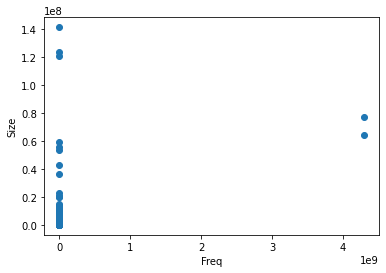

In [2]:
df_pre = pd.read_csv('./parsed/metaFromFcos.csv')
plt.ylabel("Size")
plt.xlabel("Freq")
plt.scatter(df_pre['Frequency'], df_pre['Size'])

Since there exists freq with MAX_INT, we will group them in one and treat them as separate and hence not include them as a part of this analysis

In [3]:
rust_u32_int_max = 4294967295
max_freq_row_no = []
for i, val in enumerate(df_pre['Frequency']):
    if val == rust_u32_int_max:
        max_freq_row_no.append(i)
df = df_pre.drop(max_freq_row_no).sort_values(by=['Frequency']).reset_index(drop=True)
df

,Name,Frequency,Size,Src
0,libteam-1.31-6.fc37.x86_64,0,86272,libteam-1.31-6.fc37.src.rpm
1,libassuan-2.5.5-5.fc37.x86_64,0,87000,libassuan-2.5.5-5.fc37.src.rpm
2,libseccomp-2.5.3-3.fc37.x86_64,0,152172,libseccomp-2.5.3-3.fc37.src.rpm
3,cpio-2.13-13.fc37.x86_64,0,966716,cpio-2.13-13.fc37.src.rpm
4,adcli-0.9.1-11.fc37.x86_64,0,168664,adcli-0.9.1-11.fc37.src.rpm
...,...,...,...,...
392,grub2-tools-minimal-1:2.06-63.fc37.x86_64,35,3238317,grub2-2.06-63.fc37.src.rpm
393,grub2-common-1:2.06-63.fc37.noarch,35,4671436,grub2-2.06-63.fc37.src.rpm
394,grub2-tools-1:2.06-63.fc37.x86_64,35,8060111,grub2-2.06-63.fc37.src.rpm
395,kernel-core-6.0.11-300.fc37.x86_64,117,55547726,kernel-6.0.11-300.fc37.src.rpm


### Clipped Data Visualization

s_low:  0.0 , s_hi:  55698394.08000008
f_low:  0.0 , f_hi:  35.0
Ignored: 5
Anomalitites Ignored 1.2594458438287104 %


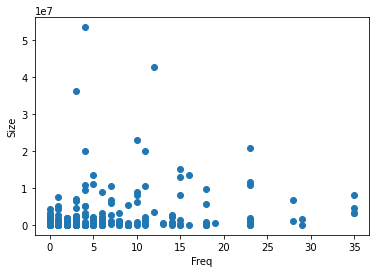

In [4]:
plt.ylabel("Size")
plt.xlabel("Freq")
s_low = df["Size"].quantile(0)
s_hi  = df["Size"].quantile(0.99)
f_low = df["Frequency"].quantile(0)
f_hi  = df["Frequency"].quantile(0.99)
print("s_low: ", s_low, ", s_hi: ", s_hi)
print("f_low: ", f_low, ", f_hi: ", f_hi)
proc = df[(df["Frequency"] <= f_hi) & (df["Frequency"] >= f_low) & (df["Size"] <= s_hi) & (df["Size"] >= s_low)]
plt.scatter(proc["Frequency"], proc["Size"])
print("Ignored:", len(df['Size']) - len(proc['Size']))
print("Anomalitites Ignored", (1-((len(proc['Size']))/len(df['Size'])))*100, "%")

### Finding Anomalies using Stat

In [5]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def outliers(col, data, threshold):
    mean = df[col].mean()
    std = df[col].std()
    threshold = threshold
    high_outlier = []
    low_outlier = []
    for i, val in enumerate(data[col]):
        if val > mean + threshold*std:
            high_outlier.append(data["Name"][i])
        if val == 0:
            low_outlier.append(data["Name"][i])
    return [high_outlier, low_outlier]

def mid(col, data, threshold):
    mean = df[col].mean()
    std = df[col].std()
    threshold = threshold
    mid = []
    for i, val in enumerate(data[col]):
        if val < mean + threshold*std and val > 0:
            mid.append(data["Name"][i])
    return mid

def map_pkg(df, pkgs):
    f_map = []
    s_map = []
    n_map = []
    for i, val in enumerate(df["Name"]):
        if val in pkgs:
            n_map.append(df["Name"][i])
            f_map.append(df["Frequency"][i])
            s_map.append(df["Size"][i])
    return [f_map, s_map, n_map]

def maxmin(arr):
    if len(arr) != 0:
        return max(arr) - min(arr)
    else:
        return "Nan"
      
    

In [6]:
h_out_freq = outliers("Frequency", df, 1.5)[0]
h_out_size = outliers("Size", df, 1.5)[0]
l_out_freq = outliers("Frequency", df, 1.5)[1]
l_out_size = outliers("Size", df, 1.5)[1]
mid_freq = mid("Frequency", df, 1.5)
mid_size = mid("Size", df, 1.5)

lf_hs = intersection(h_out_size, l_out_freq)
mf_hs = intersection(h_out_size, mid_freq)
hf_hs = intersection(h_out_freq, h_out_size)
lf_ms = intersection(mid_size, l_out_freq)
mf_ms = intersection(mid_size, mid_freq)
hf_ms = intersection(h_out_freq, mid_size)
lf_ls = intersection(l_out_freq, l_out_size)
mf_ls = intersection(mid_freq, l_out_size)
hf_ls = intersection(h_out_freq, l_out_size)

print("lf_hs:", len(lf_hs), "which is", round(len(lf_hs)/len(df['Size'])*100, 1), "% of total pkgs")
print("mf_hs:", len(mf_hs), "which is", round(len(mf_hs)/len(df['Size'])*100, 1), "% of total pkgs")
print("hf_hs:", len(hf_hs), "which is", round(len(hf_hs)/len(df['Size'])*100, 1), "% of total pkgs")
print("lf_ms:", len(lf_ms), "which is", round(len(lf_ms)/len(df['Size'])*100, 1), "% of total pkgs")
print("mf_ms:", len(mf_ms), "which is", round(len(mf_ms)/len(df['Size'])*100, 1), "% of total pkgs")
print("hf_ms:", len(hf_ms), "which is", round(len(hf_ms)/len(df['Size'])*100, 1), "% of total pkgs")
print("lf_ls:", len(lf_ls), "which is", round(len(lf_ls)/len(df['Size'])*100, 1), "% of total pkgs")
print("mf_ls:", len(mf_ls), "which is", round(len(mf_ls)/len(df['Size'])*100, 1), "% of total pkgs")
print("hf_ls:", len(hf_ls), "which is", round(len(hf_ls)/len(df['Size'])*100, 1), "% of total pkgs")

lf_hs: 0 which is 0.0 % of total pkgs
mf_hs: 7 which is 1.8 % of total pkgs
hf_hs: 2 which is 0.5 % of total pkgs
lf_ms: 103 which is 25.9 % of total pkgs
mf_ms: 265 which is 66.8 % of total pkgs
hf_ms: 19 which is 4.8 % of total pkgs
lf_ls: 0 which is 0.0 % of total pkgs
mf_ls: 1 which is 0.3 % of total pkgs
hf_ls: 0 which is 0.0 % of total pkgs


Total Size of lf_hs 0 Frequency difference: Nan
Total Size of mf_hs 541543272 Frequency difference: 12
Total Size of hf_hs 114862154 Frequency difference: 0
Total Size of lf_ms 41087584 Frequency difference: 0
Total Size of mf_ms 398574387 Frequency difference: 18
Total Size of hf_ms 76822341 Frequency difference: 12
Total Size of lf_ls 0 Frequency difference: Nan
Total Size of mf_ls 0 Frequency difference: 0
Total Size of hf_ls 0 Frequency difference: Nan


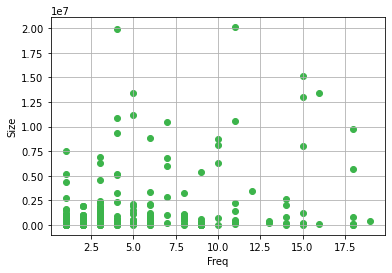

In [7]:
plt.ylabel("Size")
plt.xlabel("Freq")
#           Teal      Red        Orange     Yellow     Green      Pink      Brown      Black       Navy       
colors = ['#469990', '#e6194B', '#f58231', '#ffe119', '#3cb44b', '#f032e6', '#9A6324', '#000000', '#000075']
#plt.scatter(map_pkg(df, lf_hs)[0], map_pkg(df, lf_hs)[1], color=colors[0]) #Teal
print("Total Size of lf_hs", sum(map_pkg(df, lf_hs)[1]), "Frequency difference:", maxmin(map_pkg(df, lf_hs)[0]))

#plt.scatter(map_pkg(df, mf_hs)[0], map_pkg(df, mf_hs)[1], color=colors[1]) #Red
print("Total Size of mf_hs", sum(map_pkg(df, mf_hs)[1]), "Frequency difference:", maxmin(map_pkg(df, mf_hs)[0]))

#plt.scatter(map_pkg(df, hf_hs)[0], map_pkg(df, hf_hs)[1], color=colors[2]) #Orange
print("Total Size of hf_hs", sum(map_pkg(df, hf_hs)[1]), "Frequency difference:", maxmin(map_pkg(df, hf_hs)[0]))

#plt.scatter(map_pkg(df, lf_ms)[0], map_pkg(df, lf_ms)[1], color=colors[3]) #Yellow
print("Total Size of lf_ms", sum(map_pkg(df, lf_ms)[1]), "Frequency difference:", maxmin(map_pkg(df, lf_ms)[0]))

plt.scatter(map_pkg(df, mf_ms)[0], map_pkg(df, mf_ms)[1], color=colors[4]) #Green
print("Total Size of mf_ms", sum(map_pkg(df, mf_ms)[1]), "Frequency difference:", maxmin(map_pkg(df, mf_ms)[0]))

#plt.scatter(map_pkg(df, hf_ms)[0], map_pkg(df, hf_ms)[1], color=colors[5]) #Pink
print("Total Size of hf_ms", sum(map_pkg(df, hf_ms)[1]), "Frequency difference:", maxmin(map_pkg(df, hf_ms)[0]))

#plt.scatter(map_pkg(df, lf_ls)[0], map_pkg(df, lf_ls)[1], color=colors[6]) #Brown
print("Total Size of lf_ls", sum(map_pkg(df, lf_ls)[1]), "Frequency difference:", maxmin(map_pkg(df, lf_ls)[0]))

#plt.scatter(map_pkg(df, mf_ls)[0], map_pkg(df, mf_ls)[1], color=colors[7]) #Black 
print("Total Size of mf_ls", sum(map_pkg(df, mf_ls)[1]), "Frequency difference:", maxmin(map_pkg(df, mf_ls)[0]))

#plt.scatter(map_pkg(df, hf_ls)[0], map_pkg(df, hf_ls)[1], color=colors[8]) #Navy
print("Total Size of hf_ls", sum(map_pkg(df, hf_ls)[1]), "Frequency difference:", maxmin(map_pkg(df, hf_ls)[0]))

plt.grid()

In [8]:
median_f_m = pd.DataFrame(map_pkg(df, mf_ms)[0])[0].quantile(interpolation='lower')
median_s_m = pd.DataFrame(map_pkg(df, mf_ms)[1])[0].quantile(interpolation='lower')
#print("f:", median_f_m, "s:", median_s_m)

def create_bins(arr, bins):
    freq_arr, size_arr, name_arr = arr
    max_size = max(size_arr)
    bin_size = 0
    bin_content = []
    start = 0
    for i, _freq_pkg in enumerate(freq_arr):
        size_pkg = size_arr[i]
        bin_content.append(name_arr[i])
        bin_size += size_pkg
        
        if bin_size > max_size:
            bin_content.pop()
            bins.append({
                "content" : bin_content.copy(),
                "size" : bin_size - size_pkg,
                "freq_diff" : maxmin(freq_arr[start: i+1]),
            })
            bin_content.clear()
            bin_content.append(name_arr[i])
            bin_size = size_pkg
            start = i
        
        elif bin_size == max_size:
            bins.append({
                "content" : bin_content.copy(),
                "size" : bin_size,
                "freq_diff" : maxmin(freq_arr[start: i+1]),
            })
            bin_size = 0
            bin_content.clear()
            start = i + 1
            
        if i == len(freq_arr) - 1:
            bins.append({
            "content" : bin_content.copy(),
            "size" : bin_size,
            "freq_diff" : maxmin(freq_arr[start: i+1]),
            })
        
    return bins

bins = []
create_bins(map_pkg(df, mf_hs), bins)
create_bins(map_pkg(df, hf_hs), bins)
create_bins(map_pkg(df, lf_ms), bins)
create_bins(map_pkg(df, mf_ms), bins)
create_bins(map_pkg(df, hf_ms), bins)
print("Total pkgs in quads: ", len(mf_hs) + len(hf_hs) + len(lf_ms) + len(mf_ms) + len(hf_ms))
print("Total bins formed: ", len(bins))

pkgs_bin = 0
for each_bin in bins:
    pkgs_bin += len(each_bin["content"])
print("Total pkgs in bins formed: ", pkgs_bin)

Total pkgs in quads:  396
Total bins formed:  49
Total pkgs in bins formed:  396


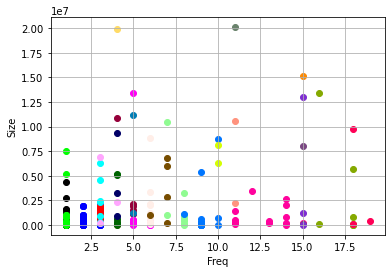

In [10]:
def plot_bins(bins):
    plt.ylabel("Size")
    plt.xlabel("Freq")  
    colors = ['#000000','#00FF00','#0000FF','#FF0000','#01FFFE','#FFA6FE','#FFDB66','#006401','#010067','#95003A','#007DB5','#FF00F6','#FFEEE8','#774D00','#90FB92','#0076FF','#D5FF00','#FF937E','#6A826C','#FF029D','#FE8900','#7A4782','#7E2DD2','#85A900','#FF0056','#A42400','#00AE7E','#683D3B','#BDC6FF','#263400','#BDD393','#00B917','#9E008E','#001544','#C28C9F','#FF74A3','#01D0FF','#004754','#E56FFE','#788231','#0E4CA1','#91D0CB','#BE9970','#968AE8','#BB8800','#43002C','#DEFF74','#00FFC6','#FFE502','#620E00','#008F9C','#98FF52','#7544B1','#B500FF','#00FF78','#FF6E41','#005F39','#6B6882','#5FAD4E','#A75740','#A5FFD2','#FFB167','#009BFF','#E85EBE',]
    for i, each_bin in enumerate(bins):
        plt.scatter(map_pkg(df, each_bin["content"])[0], map_pkg(df, each_bin["content"])[1], color=colors[i])
    plt.grid()

plot_bins(create_bins(map_pkg(df, mf_ms), []))

In [9]:
def basic_packing(components, bins):
    bins = []
    # remove high freq anomaly and pack them as a bin
    # define max bin size to max(components.size)
    # Aim to minimize frequency maxmin(bin)
    # get freq/size (LHM) 9 parts
    # for the part with size>Max_SIZE and freq>max_min, recursively find median (0.5 quntile) of freqequncy
    # and use that as a partition to split the pkgs according to frequqncy. When once found fb<bands<fa, add
    # to bin by first size
    # Prevent doing a package structure change
    return

In [8]:
basic_packing(query, 64)